# Data Collection

In [22]:
#modules for data collection and pre-processing
from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv

#modules for visualization and analysis
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns

sns.set_style("white")

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

Module for scraping public store and output a csv of listing urls

In [23]:
def get_ads_urls():
    urls_list = []
    basic_url = "https://www.avito.ma/fr/maroc/voitures-à_vendre?mpr=500000000&o="
    for i in range(1,250):
        url = basic_url+str(i)
        r  = requests.get(url)
        data = r.text
        soup = BeautifulSoup(data, 'lxml')
        for div in soup.findAll('div', {'class': 'item-img'}):
            a = div.findAll('a')[0]
            urls_list.append(a.get('href'))


    df = pd.DataFrame(data={"url": urls_list})
    df.to_csv("./ads_urls.csv", sep=',',index=False)

In [24]:
get_ads_urls()

In [25]:
def scrap_ad_data(ad_url):
    r=requests.get(ad_url)
    data=r.text
    soup=BeautifulSoup(data,"html.parser")
    target_component=soup.findAll("h2",{"class":["font-normal", "fs12", "no-margin", "ln22"]})
    results=[]
    for i in target_component:
        results.append(''.join(i.findAll(text=True)).replace('\n',''))
    return results
    

In [26]:
def write_data_to_csv(data):
    with open("./output.csv","w") as f:
        writer=csv.writer(f)
        writer.writerows(data)

In [27]:
urls_data=pd.read_csv("./ads_urls.csv")
final_result=[]
i=1

for index, row in urls_data.iterrows():
    final_result.append(scrap_ad_data(row['url']))
    
print('Data scrap end')

write_data_to_csv(final_result)

Data scrap end


# Data Preprocessing and cleaning

In [28]:
# set the column names
colnames=['price', 'year_model', 'mileage', 'fuel_type', 'mark', 'model', 'fiscal_power', 'sector', 'type', 'city'] 

df = pd.read_csv("./output.csv", encoding = "ISO-8859-1", sep=",", names=colnames, header=None)

df.head()

,price,year_model,mileage,fuel_type,mark,model,fiscal_power,sector,type,city
0,45 000 DH,Année-Modèle:1998,Kilométrage:450 000 - 499 999,Type de carburant:Diesel,Marque:Renault,Modèle:EXPRESS,Puissance fiscale:7 CV,-,"Type:Voitures, Offre",Marrakech
1,57 000 DH,Année-Modèle:2010,Kilométrage:130 000 - 139 999,Type de carburant:Essence,Marque:Peugeot,Modèle:206+,Puissance fiscale:6 CV,-,"Type:Voitures, Offre",Marrakech
2,24 000 DH,Année-Modèle:2017,Kilométrage:15 000 - 19 999,Type de carburant:Diesel,Marque:Hyundai,Modèle:Tucson,Puissance fiscale:7 CV,-,"Type:Voitures, Offre",Casablanca
3,63 000 DH,Année-Modèle:2002,Kilométrage:120 000 - 129 999,Type de carburant:Essence,Marque:Mercedes-Benz,Modèle:Classe CLK,Puissance fiscale:15 CV,Secteur:centre_ville,"Type:Voitures, Offre",Casablanca
4,119 000 DH,Année-Modèle:2013,Kilométrage:95 000 - 99 999,Type de carburant:Diesel,Marque:Mitsubishi,Modèle:L200,Puissance fiscale:9 CV,Secteur:maarif,"Type:Voitures, Offre",Casablanca


In [29]:
df= df[df.price.str.contains("DH")==True]
df.price=df.price.map(lambda x:x.rstrip('DH'))
df.price=df.price.str.replace(" ","")
df.price=pd.to_numeric(df.price, errors='coerce', downcast='integer')

df=df[df.year_model.str.contains("Année-Modèle")==True]
df.year_model=df.year_model.map(lambda x:x.lstrip('Année-Modèle:').rstrip('ou plus ancien'))
df=df[df.year_model != ' -']
df=df[df.year_model !='']
df.year_model=pd.to_numeric(df.year_model, errors='coerce', downcast='integer')

df=df[df.mileage.str.contains("Kilométrage")== True]
df.mileage = df.mileage.map(lambda x:x.lstrip('Kilométrage:'))
df.mileage = df.mileage.map(lambda x:x.lstrip('Plus de '))
df=df[df.mileage !='-']

if any(df.mileage != '500 000'):
    df['minim'],df['maxim']=df.mileage.str.split('-',1).str
    df['maxim']=df.maxim.str.replace(" ","")
    df['minim']=df.minim.str.replace(" ","")
    df['maxim']=df['maxim'].replace(np.nan, 500000)
    df.mileage = df.apply(lambda row: (int(row.minim)+int(row.maxim))/2, axis =1)
    df=df.drop(columns=['minim', 'maxim'])
    
df.fuel_type=df.fuel_type.map(lambda x:x.lstrip('Type de carburant:'))  

df['mark']=df['mark'].map(lambda x:x.replace('Marque:',''))
df=df[df.mark!='-']
df['model']=df['model'].map(lambda x:x.replace('Modèle:',''))

df.fiscal_power = df.fiscal_power.map(lambda x: x.lstrip('Puissance fiscale:Plus de').rstrip(' CV'))
df.fiscal_power =df.fiscal_power.str.replace("-","0")
df.fiscal_power=pd.to_numeric(df.fiscal_power, errors='coerce', downcast='integer')
df.fiscal_power=df.fiscal_power.map(lambda x:df.fiscal_power.mean() if x == 0 else x)

df=df[df.fuel_type!='-']

df=df.drop(columns=['sector','type'])

In [30]:
df.head

<bound method NDFrame.head of        price  year_model   mileage fuel_type           mark  \
0      45000        1998  474999.5    Diesel        Renault   
1      57000        2010  134999.5   Essence        Peugeot   
2      24000        2017   17499.5    Diesel        Hyundai   
3      63000        2002  124999.5   Essence  Mercedes-Benz   
4     119000        2013   97499.5    Diesel     Mitsubishi   
5      15000        2012  124999.5    Diesel           Ford   
6      55000        2008  174999.5    Diesel        Peugeot   
7      13000        1991   22499.5   Essence        Renault   
8      59000        2011   67499.5   Essence        Renault   
9     230000        2010  174999.5    Diesel     Land Rover   
10     85000        2010  164999.5    Diesel        Renault   
11     56000        2010   82499.5    Diesel     Volkswagen   
12     42000        1986   32499.5    Diesel  Mercedes-Benz   
13    107000        2008  164999.5   Essence        Hyundai   
14     28000        1997 

In [82]:
df.fiscal_power.value_counts()

4.455733     3488
6.000000     1682
8.000000     1295
7.000000     1043
9.000000      298
5.000000      190
10.000000     177
11.000000     165
12.000000     126
4.000000       27
13.000000      14
17.000000      13
14.000000       9
20.000000       9
15.000000       6
21.000000       5
18.000000       5
16.000000       4
31.000000       4
48.000000       4
24.000000       3
30.000000       3
19.000000       1
25.000000       1
29.000000       1
Name: fiscal_power, dtype: int64

# Exploratory analysis and visualization

price distribution by year_model

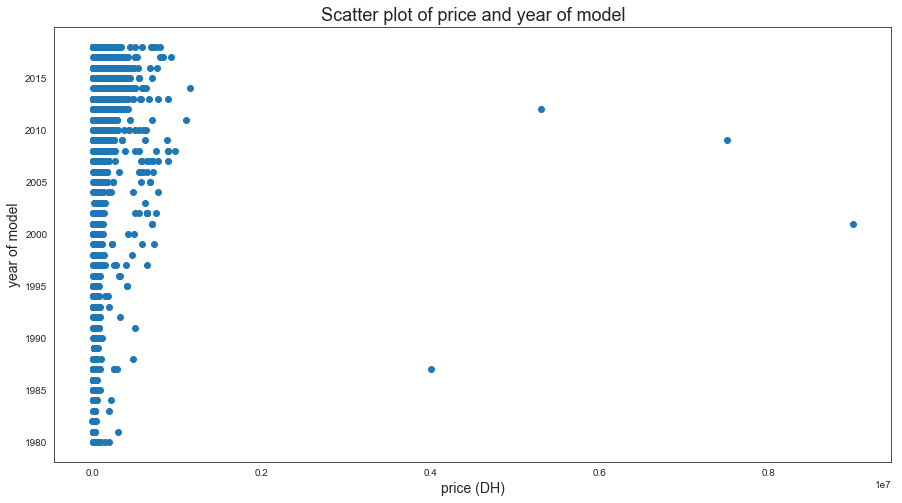

In [31]:
plt.figure(figsize=(15,8))
plt.scatter(df.price,df.year_model)
plt.xlabel("price (DH)",fontsize=14)
plt.ylabel("year of model",fontsize=14)
plt.title("Scatter plot of price and year of model",fontsize=18)
plt.show()

price distribution by mark

<function matplotlib.pyplot.show(*args, **kw)>

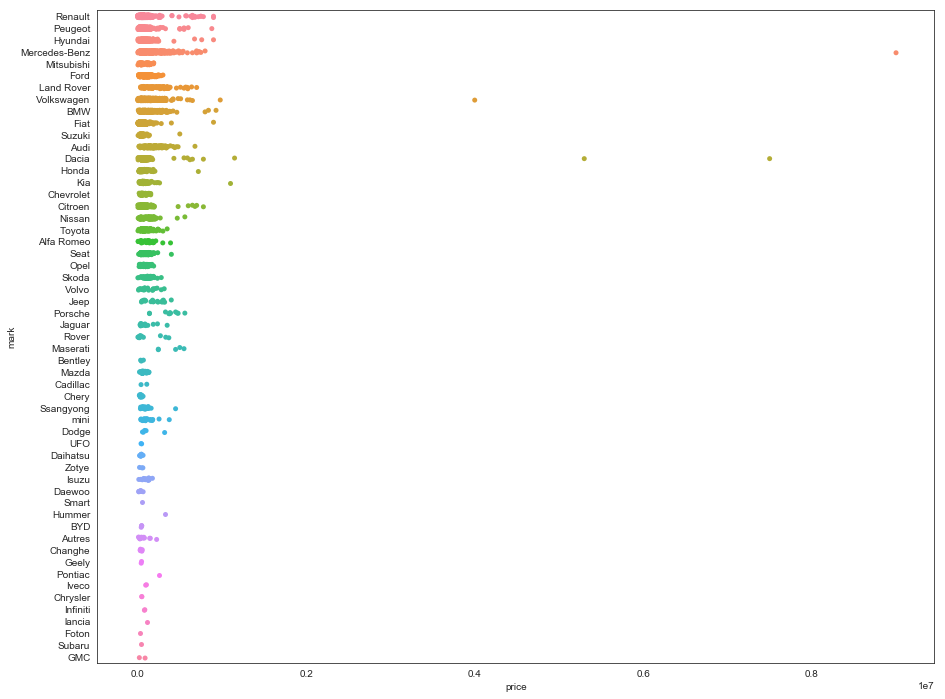

In [32]:
f, ax=plt.subplots(figsize=(15,12))
sns.stripplot(data=df, x='price', y='mark', jitter=.1)
plt.show

price distribution by fiscal power

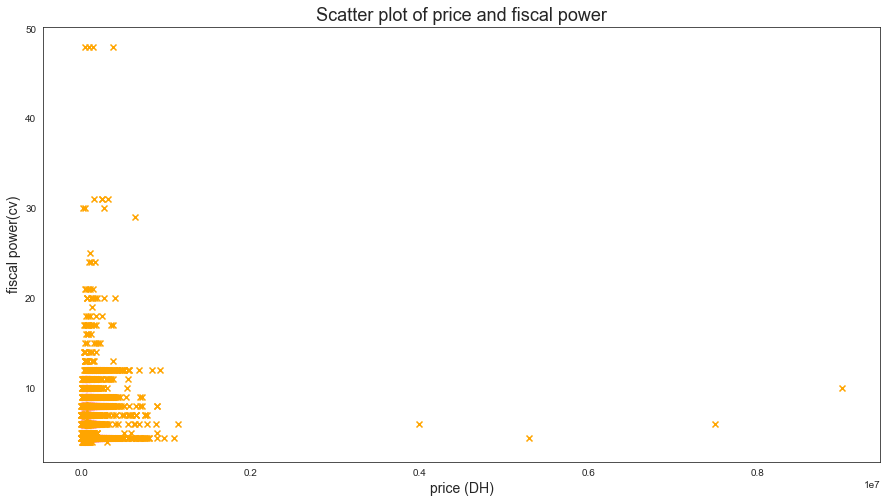

In [33]:
plt.figure(figsize=(15,8))
plt.scatter(df.price,df.fiscal_power,c='orange',marker='x')
plt.xlabel("price (DH)",fontsize=14)
plt.ylabel("fiscal power(cv)",fontsize=14)
plt.title("Scatter plot of price and fiscal power",fontsize=18)
plt.show()

top 20 mark distribution

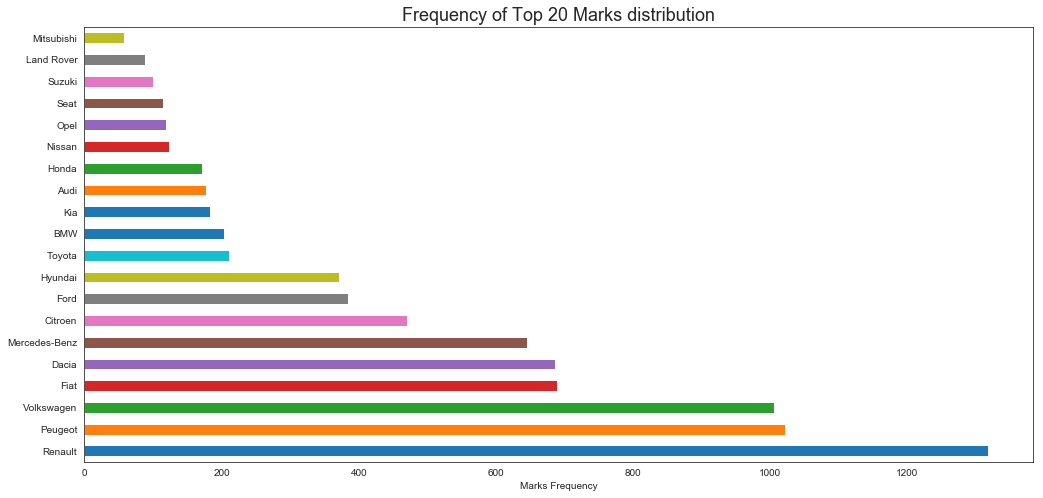

In [34]:
plt.figure(figsize=(17,8))
df.mark.value_counts().nlargest(20).plot(kind='barh')
plt.xlabel('Marks Frequency')
plt.title("Frequency of Top 20 Marks distribution",fontsize=18)
plt.show()

price distribution by fuel type

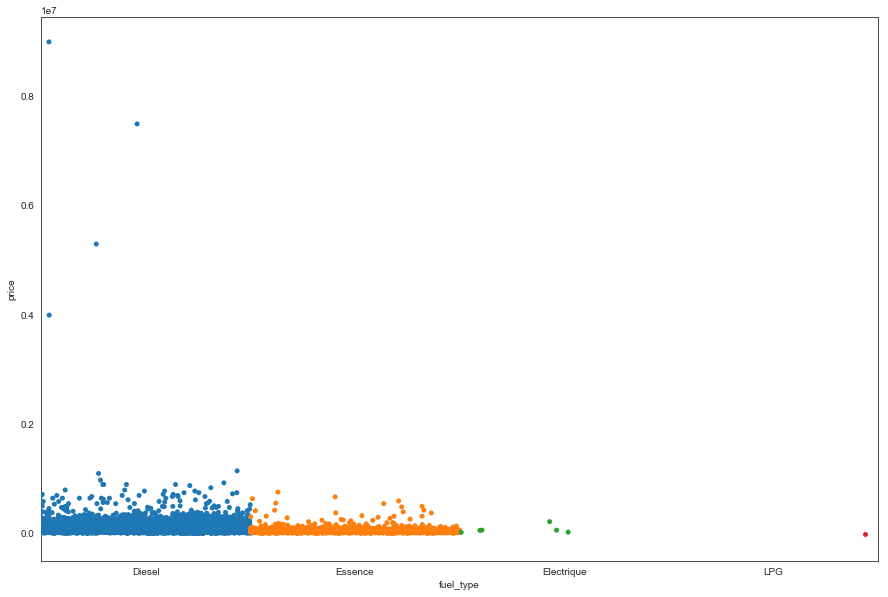

In [35]:
f, ax =plt.subplots(figsize=(15,10))
sns.stripplot(data=df,x='fuel_type',y='price',jitter=.5)
plt.show()

e:\python\projects\deploying-machine-learning-model-to-heroku\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


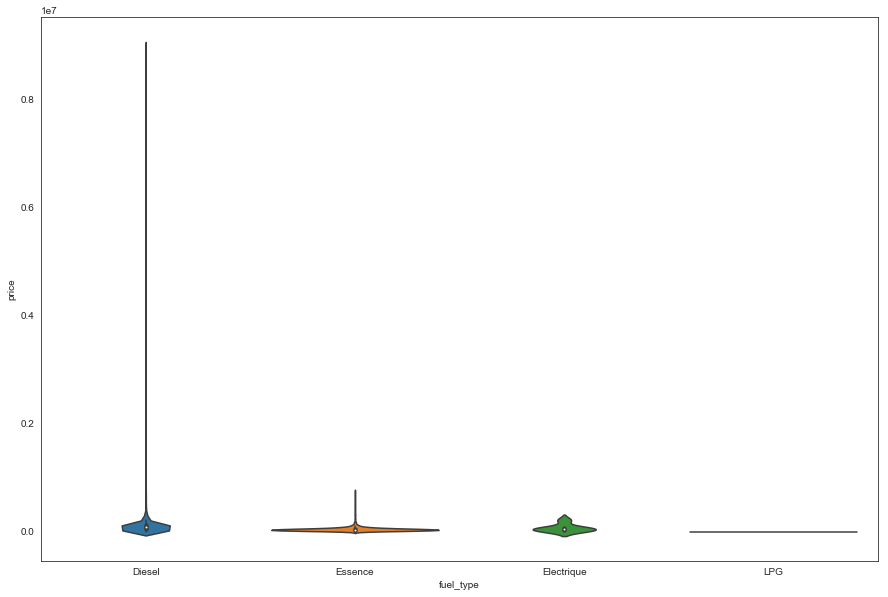

In [36]:
f, ax=plt.subplots(figsize=(15,10))
sns.violinplot(data=df, x='fuel_type',y='price')
plt.show()

Price distribution by mileage and fuel type

In [37]:
color_dict={'Diesel':'blue','Essence':'orange','Electrique':'yellow','LPG':'magenta'}

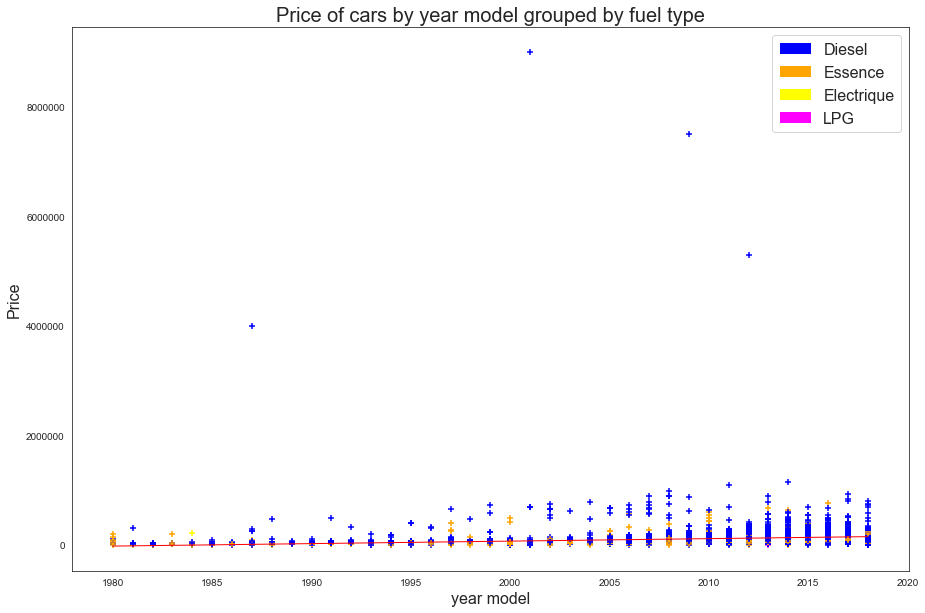

In [39]:
fig, ax= plt.subplots(figsize=(15,10))
plt.plot(np.unique(df.year_model),np.poly1d(np.polyfit(df.year_model,df.price,1))(np.unique(df.year_model)),c='red',linewidth=1)
plt.scatter(df.year_model,df.price, c=[color_dict[i] for i in df.fuel_type],marker='+')
fuel_type=df.fuel_type.unique()
recs=[]
for i in fuel_type:
    recs.append(mpatches.Rectangle((2,2),1,1,fc=color_dict[i]))
    plt.legend(recs,fuel_type,loc=1,fontsize=16)
    
plt.title('Price of cars by year model grouped by fuel type',fontsize=20)
plt.ylabel('Price',fontsize=16)
plt.xlabel('year model', fontsize=16)
xvals=ax.get_xticks()
ax.set_xticklabels(['{}'.format(int(x)) for x in xvals])

yvals=ax.get_yticks()
ax.set_yticklabels(['{}'.format(int(y)) for y in yvals])

plt.show()

correlation matrix

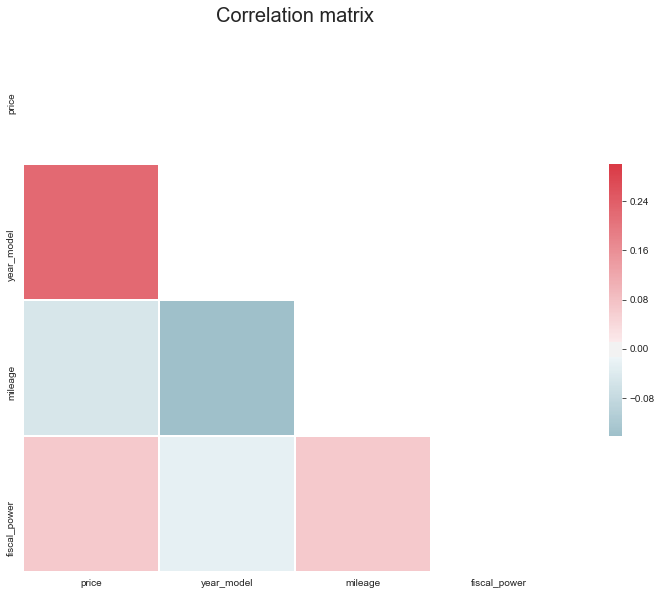

In [42]:
cmap=sns.diverging_palette(220, 10, as_cmap=True)
f, ax =plt.subplots(figsize=(15,10))
corr=df.corr()
mask=np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.3,center=0,square=True,linewidths=.5,cbar_kws={"shrink":.5})
plt.title('Correlation matrix',fontsize=20)
plt.show()

ads distribution by city

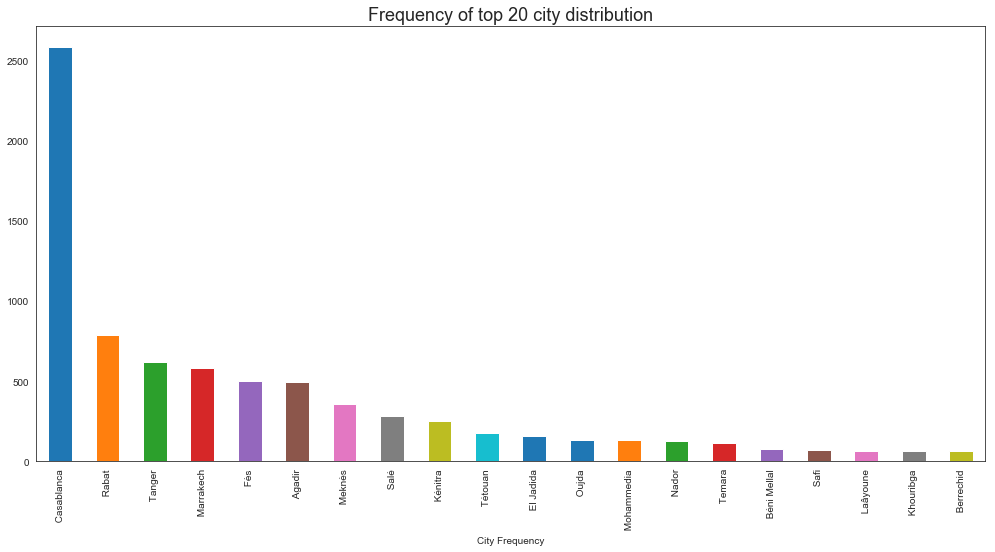

In [43]:
plt.figure(figsize=(17,8))
df.city.value_counts().nlargest(20).plot(kind='bar')
plt.xlabel('City Frequency')
plt.title("Frequency of top 20 city distribution",fontsize=18)
plt.show()

# Data Modelling

knn regression

In [44]:
data=df[df.price < 400000]

In [45]:
df.head()

,price,year_model,mileage,fuel_type,mark,model,fiscal_power,city
0,45000,1998,474999.5,Diesel,Renault,EXPRESS,7.0,Marrakech
1,57000,2010,134999.5,Essence,Peugeot,206+,6.0,Marrakech
2,24000,2017,17499.5,Diesel,Hyundai,Tucson,7.0,Casablanca
3,63000,2002,124999.5,Essence,Mercedes-Benz,Classe CLK,15.0,Casablanca
4,119000,2013,97499.5,Diesel,Mitsubishi,L200,9.0,Casablanca


handle categorical features

In [46]:
X = data[['year_model','mileage','fiscal_power','fuel_type','mark']]
Y = data.price
X = pd.get_dummies(data=X)

In [47]:
X.head()

,year_model,mileage,fiscal_power,fuel_type_Diesel,fuel_type_Electrique,fuel_type_Essence,fuel_type_LPG,mark_Alfa Romeo,mark_Audi,mark_Autres,...,mark_Ssangyong,mark_Subaru,mark_Suzuki,mark_Toyota,mark_UFO,mark_Volkswagen,mark_Volvo,mark_Zotye,mark_lancia,mark_mini
0,1998,474999.5,7.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2010,134999.5,6.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017,17499.5,7.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2002,124999.5,15.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013,97499.5,9.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Data splitting - Train, validation + test

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=.20, random_state =42)

In [84]:
X_train

,year_model,mileage,fiscal_power,fuel_type_Diesel,fuel_type_Electrique,fuel_type_Essence,fuel_type_LPG,mark_Alfa Romeo,mark_Audi,mark_Autres,...,mark_Ssangyong,mark_Subaru,mark_Suzuki,mark_Toyota,mark_UFO,mark_Volkswagen,mark_Volvo,mark_Zotye,mark_lancia,mark_mini
4092,2013,77499.5,6.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6942,2006,224999.5,6.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3787,2005,224999.5,6.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4086,2001,144999.5,7.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1626,2001,2499.5,4.455733,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1452,2009,47499.5,5.000000,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4698,2005,224999.5,8.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6077,2013,184999.5,8.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5890,2015,144999.5,8.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7188,2006,224999.5,4.455733,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
X_test

,year_model,mileage,fiscal_power,fuel_type_Diesel,fuel_type_Electrique,fuel_type_Essence,fuel_type_LPG,mark_Alfa Romeo,mark_Audi,mark_Autres,...,mark_Ssangyong,mark_Subaru,mark_Suzuki,mark_Toyota,mark_UFO,mark_Volkswagen,mark_Volvo,mark_Zotye,mark_lancia,mark_mini
6855,2013,114999.5,6.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6831,2012,114999.5,4.455733,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
651,2004,224999.5,4.455733,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5092,2010,92499.5,11.000000,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
858,2011,194999.5,5.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1598,2013,124999.5,8.000000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6818,1987,42499.5,4.455733,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1977,2008,194999.5,6.000000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5446,2010,144999.5,8.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7426,2010,164999.5,6.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
Y_train

4092    118000
6942     52500
3787     73000
4086     35000
1626     52000
1452     29000
4698     67000
6077    235000
5890    174000
7188     70000
1548     98000
2703    148000
8543     66000
5505    160000
872      66000
1181    155000
4624     35000
5146     36000
5233     57000
7277    118000
1288     70000
483     193000
7251     47000
5360    195000
5257    150000
7030     85000
5984     15000
3249     85000
396      65000
3086     70000
         ...  
1950     75000
4783     15000
3091    113000
2815    240000
200     310000
2828     53000
2102     50000
8053     95000
2632     58000
6561     43000
3477    105000
4678     26000
1219     90000
6585     59000
5186     82000
5451     55000
2502    117000
7134     26000
799      27000
1731    250000
8541     26000
5723     55000
4544     52000
486      59000
6424     60000
5880     65000
5328     41000
5534     85000
891      50000
7461     50000
Name: price, Length: 6767, dtype: int32

In [87]:
Y_test

6855     82000
6831     57000
651     103000
5092    235000
858      77000
1598     46000
6818     35000
1977     49000
5446    145000
7426     69000
4364     85000
4766     75000
7646    105000
5133    160000
7112     53000
3598     73000
4705    220000
33       47000
1688     78000
371      68000
8003    135000
1087    135000
5129     38000
973      60000
7943    100000
6798     67000
1424    117000
6020     28000
7572     57000
8419     35000
         ...  
1816     60000
7820     48000
7389     42000
6532     50000
3638     72000
7179    350000
4656     37000
585     150000
7177     80000
4781    125000
1869     33000
8579     52000
3745    100000
3469    115000
4486    250000
6383    129000
2762     50000
8656     26000
7068     63000
1081    142000
7439    200000
5143     78000
434      37000
4420     95000
7682     50000
5902     13500
2798     42000
4310     50000
6536    228000
5412     30000
Name: price, Length: 1692, dtype: int32

e:\python\projects\deploying-machine-learning-model-to-heroku\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


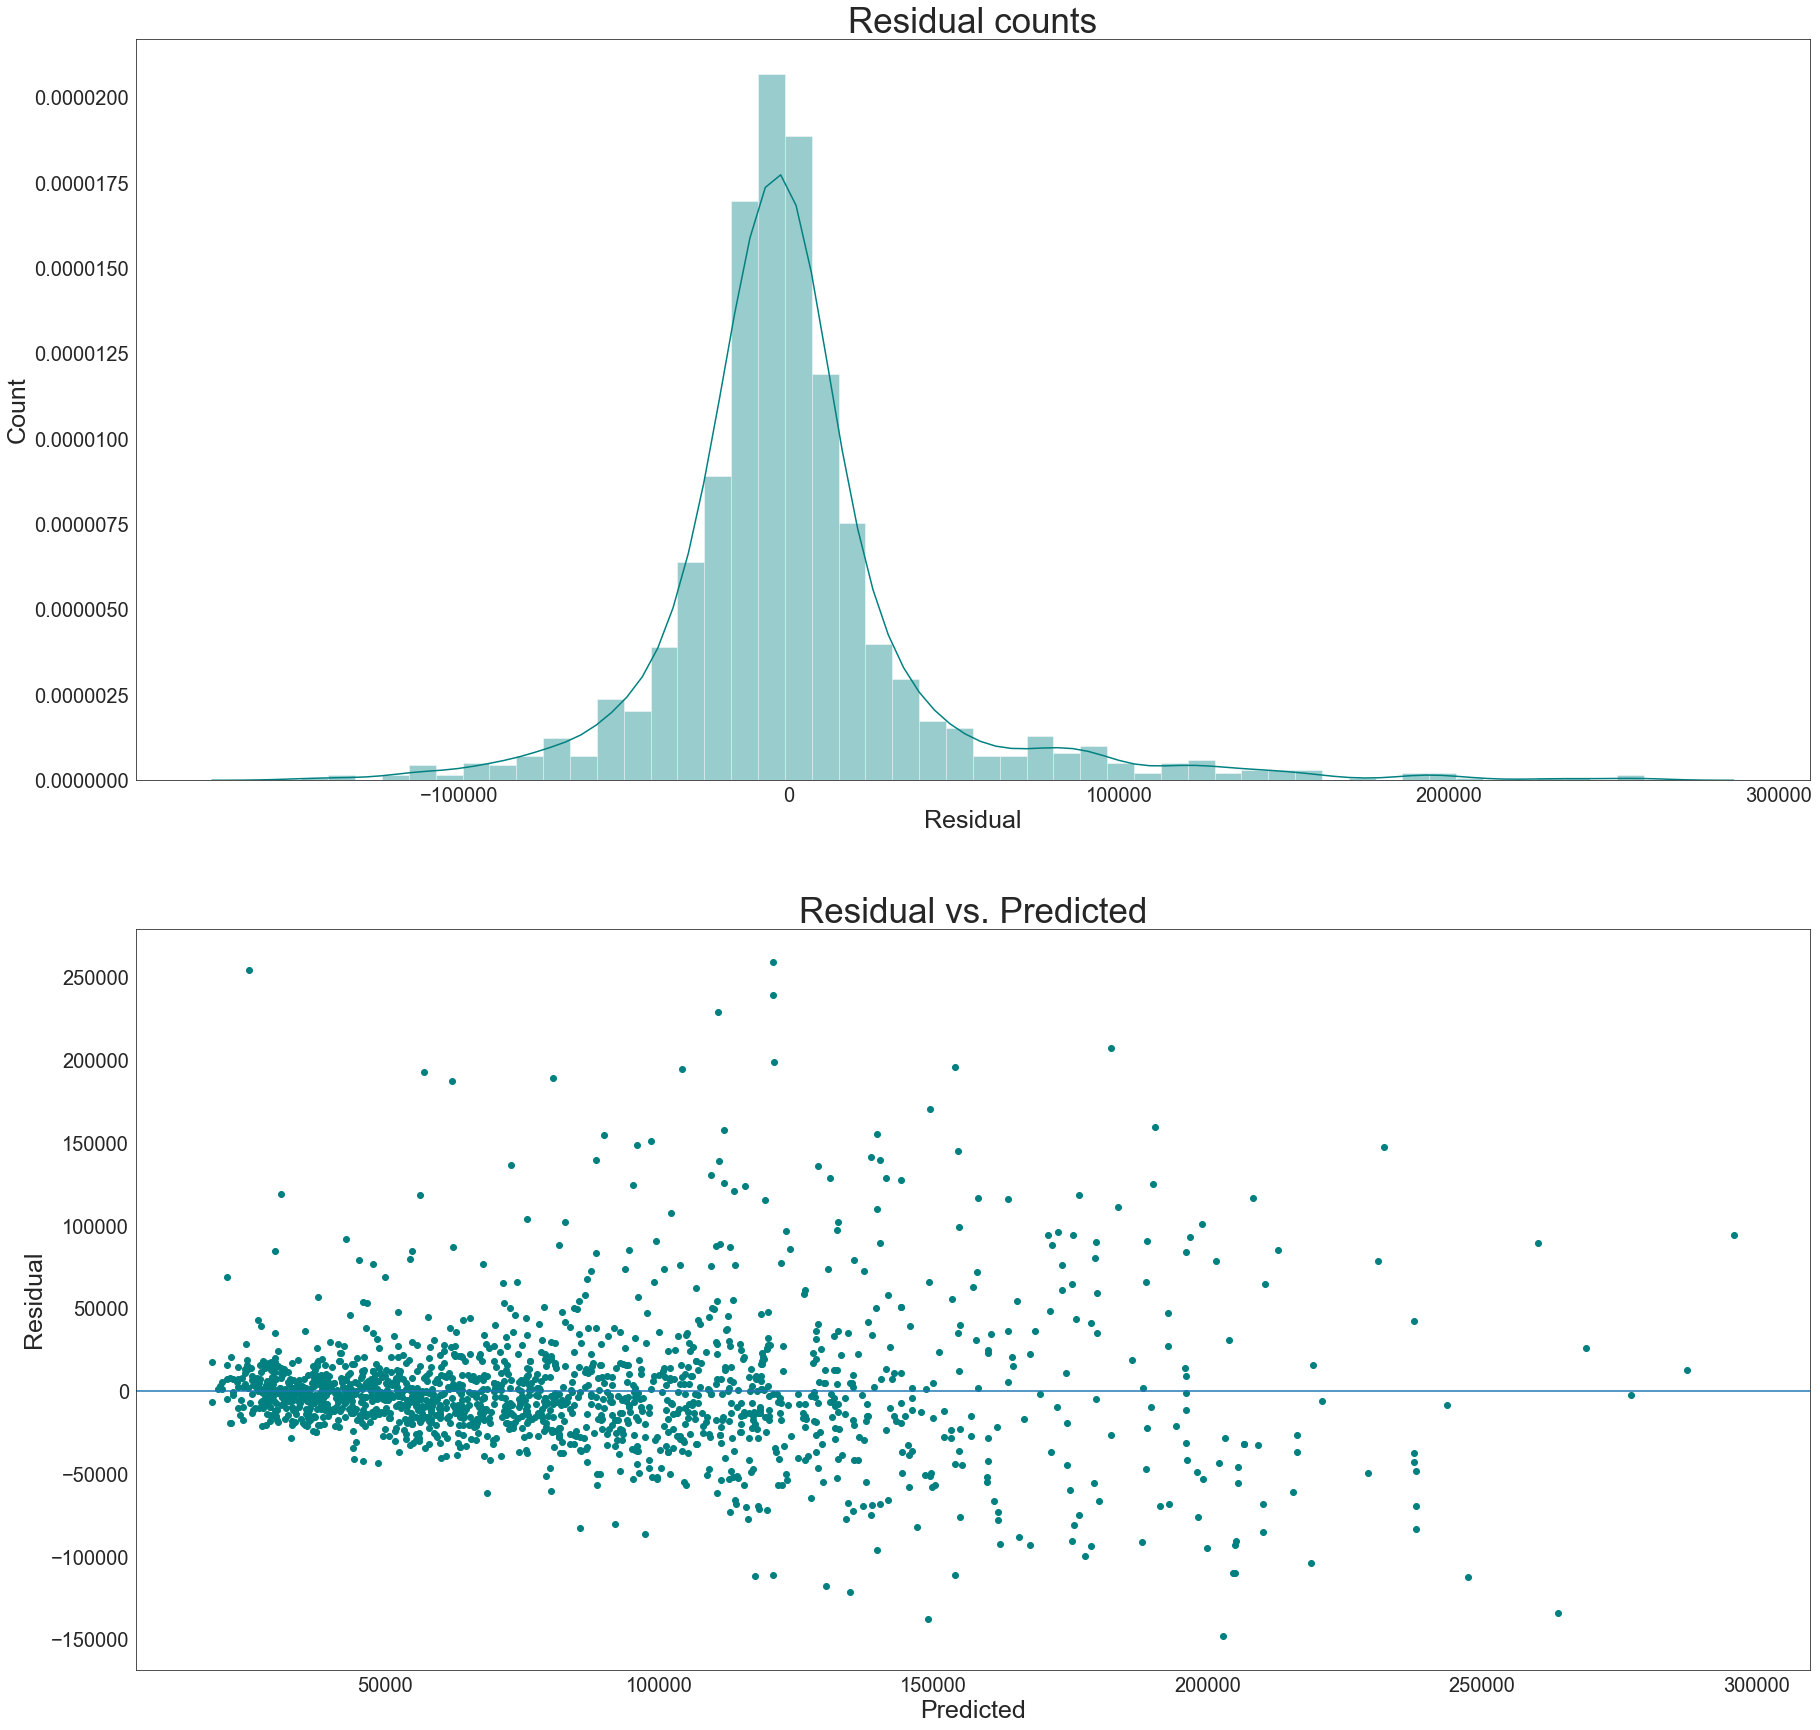

RMSE:
40031.03250433117


In [88]:
from sklearn import neighbors
knn=neighbors.KNeighborsRegressor(n_neighbors=6)
knn.fit(X_train, Y_train)

predicted = knn.predict(X_test)
residual=Y_test- predicted

fig=plt.figure(figsize=(30,30))
ax1=plt.subplot(211)
sns.distplot(residual, color='teal')
plt.tick_params(axis='both',which='major',labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2=plt.subplot(212)
plt.scatter(predicted, residual, color='teal')
plt.tick_params(axis='both',which='major',labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

In [89]:
from sklearn.metrics import r2_score
print('Variance score: %.2f'%r2_score(Y_test,predicted))

Variance score: 0.57


In [90]:
rmse_l=[]
num=[]
for n in range (2,16):
    knn=neighbors.KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train,Y_train)
    predicted=knn.predict(X_test)
    rmse_l.append(np.sqrt(mean_squared_error(Y_test,predicted)))
    num.append(n)

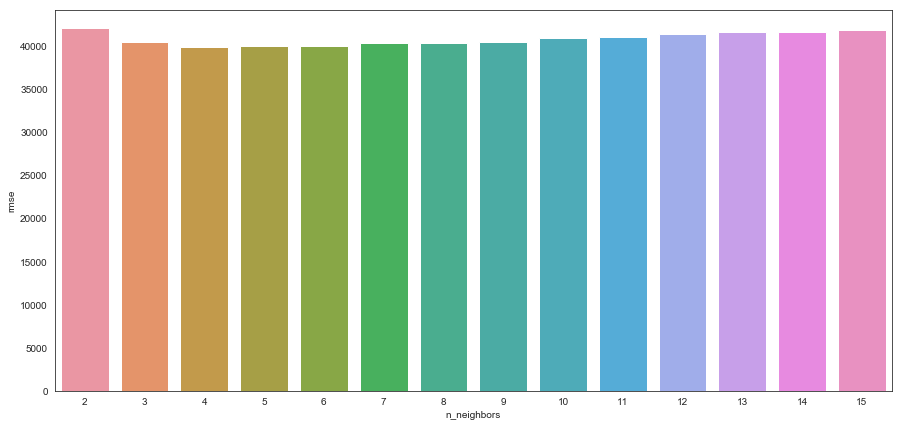

In [91]:
df_plt=pd.DataFrame()
df_plt['rmse']=rmse_l
df_plt['n_neighbors']=num
ax=plt.figure(figsize=(15,7))
sns.barplot(data=df_plt, x='n_neighbors',y='rmse')
plt.show()

Decision tree regression

e:\python\projects\deploying-machine-learning-model-to-heroku\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


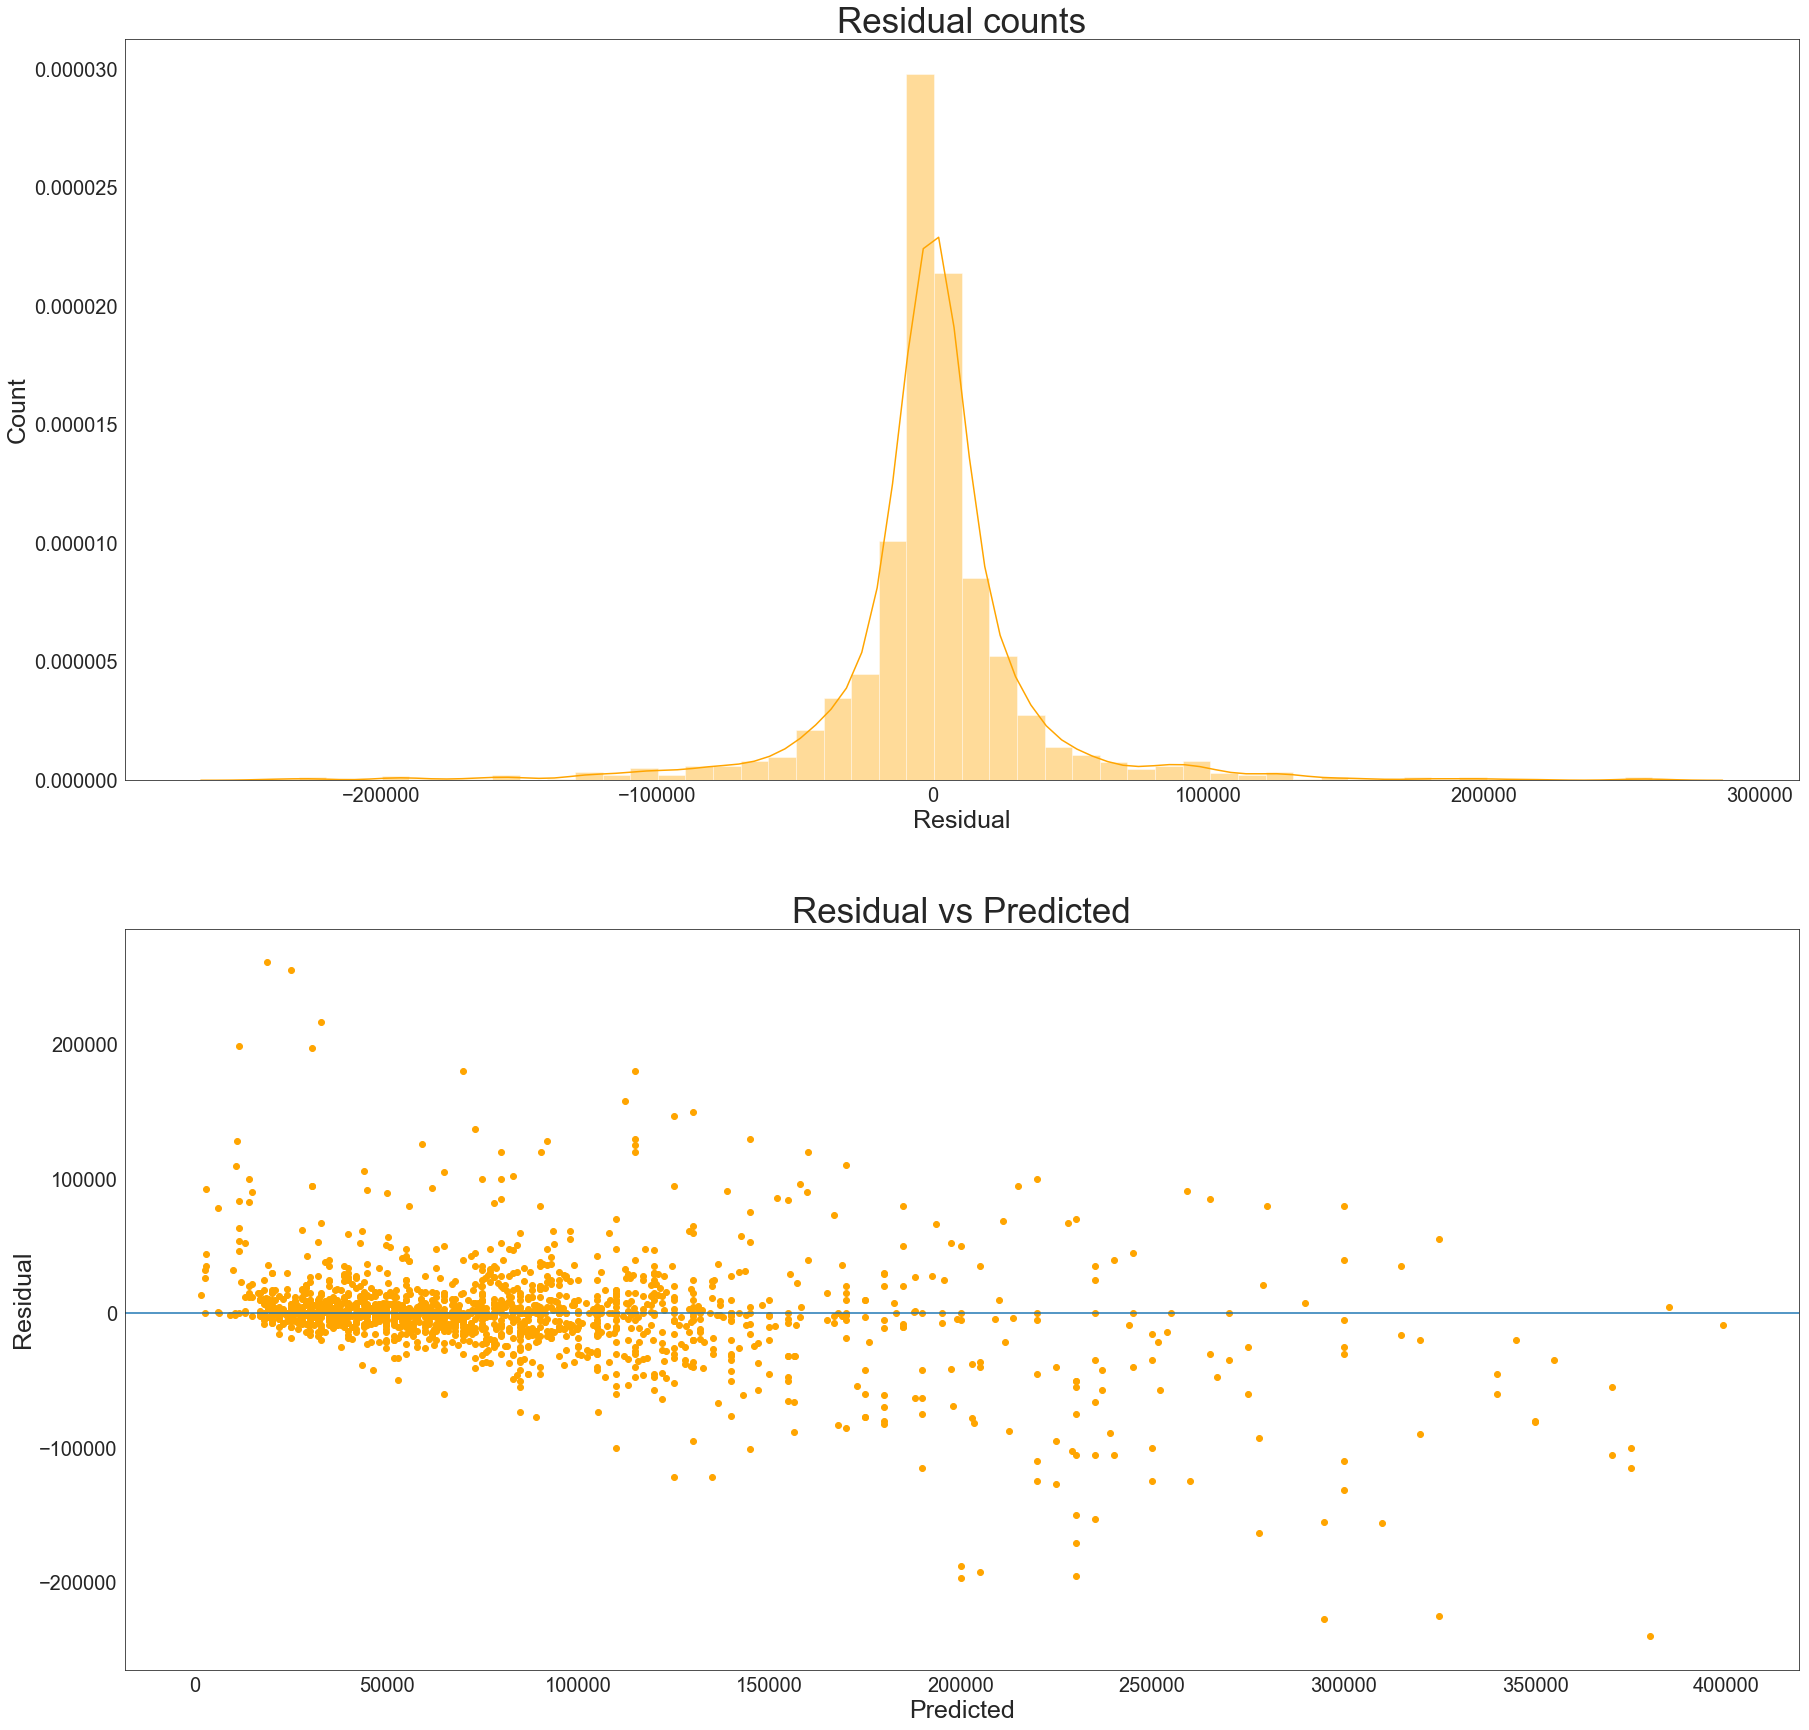

RMSE: 
37638.28736676515


In [92]:
from sklearn.tree import DecisionTreeRegressor

dtr=DecisionTreeRegressor(max_features='auto')
dtr.fit(X_train, Y_train)
predicted=dtr.predict(X_test)
residual=Y_test-predicted

fig=plt.figure(figsize=(30,30))
ax1=plt.subplot(211)
sns.distplot(residual,color='orange')
plt.tick_params(axis='both',which='major',labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2=plt.subplot(212)
plt.scatter(predicted, residual, color='orange')
plt.tick_params(axis='both',which='major',labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse=np.sqrt(mean_squared_error(Y_test,predicted))
print("RMSE: ")
print(rmse)

In [93]:
print('Variance score: %.2f'% r2_score(Y_test,predicted))

Variance score: 0.62


Linear Regression

e:\python\projects\deploying-machine-learning-model-to-heroku\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


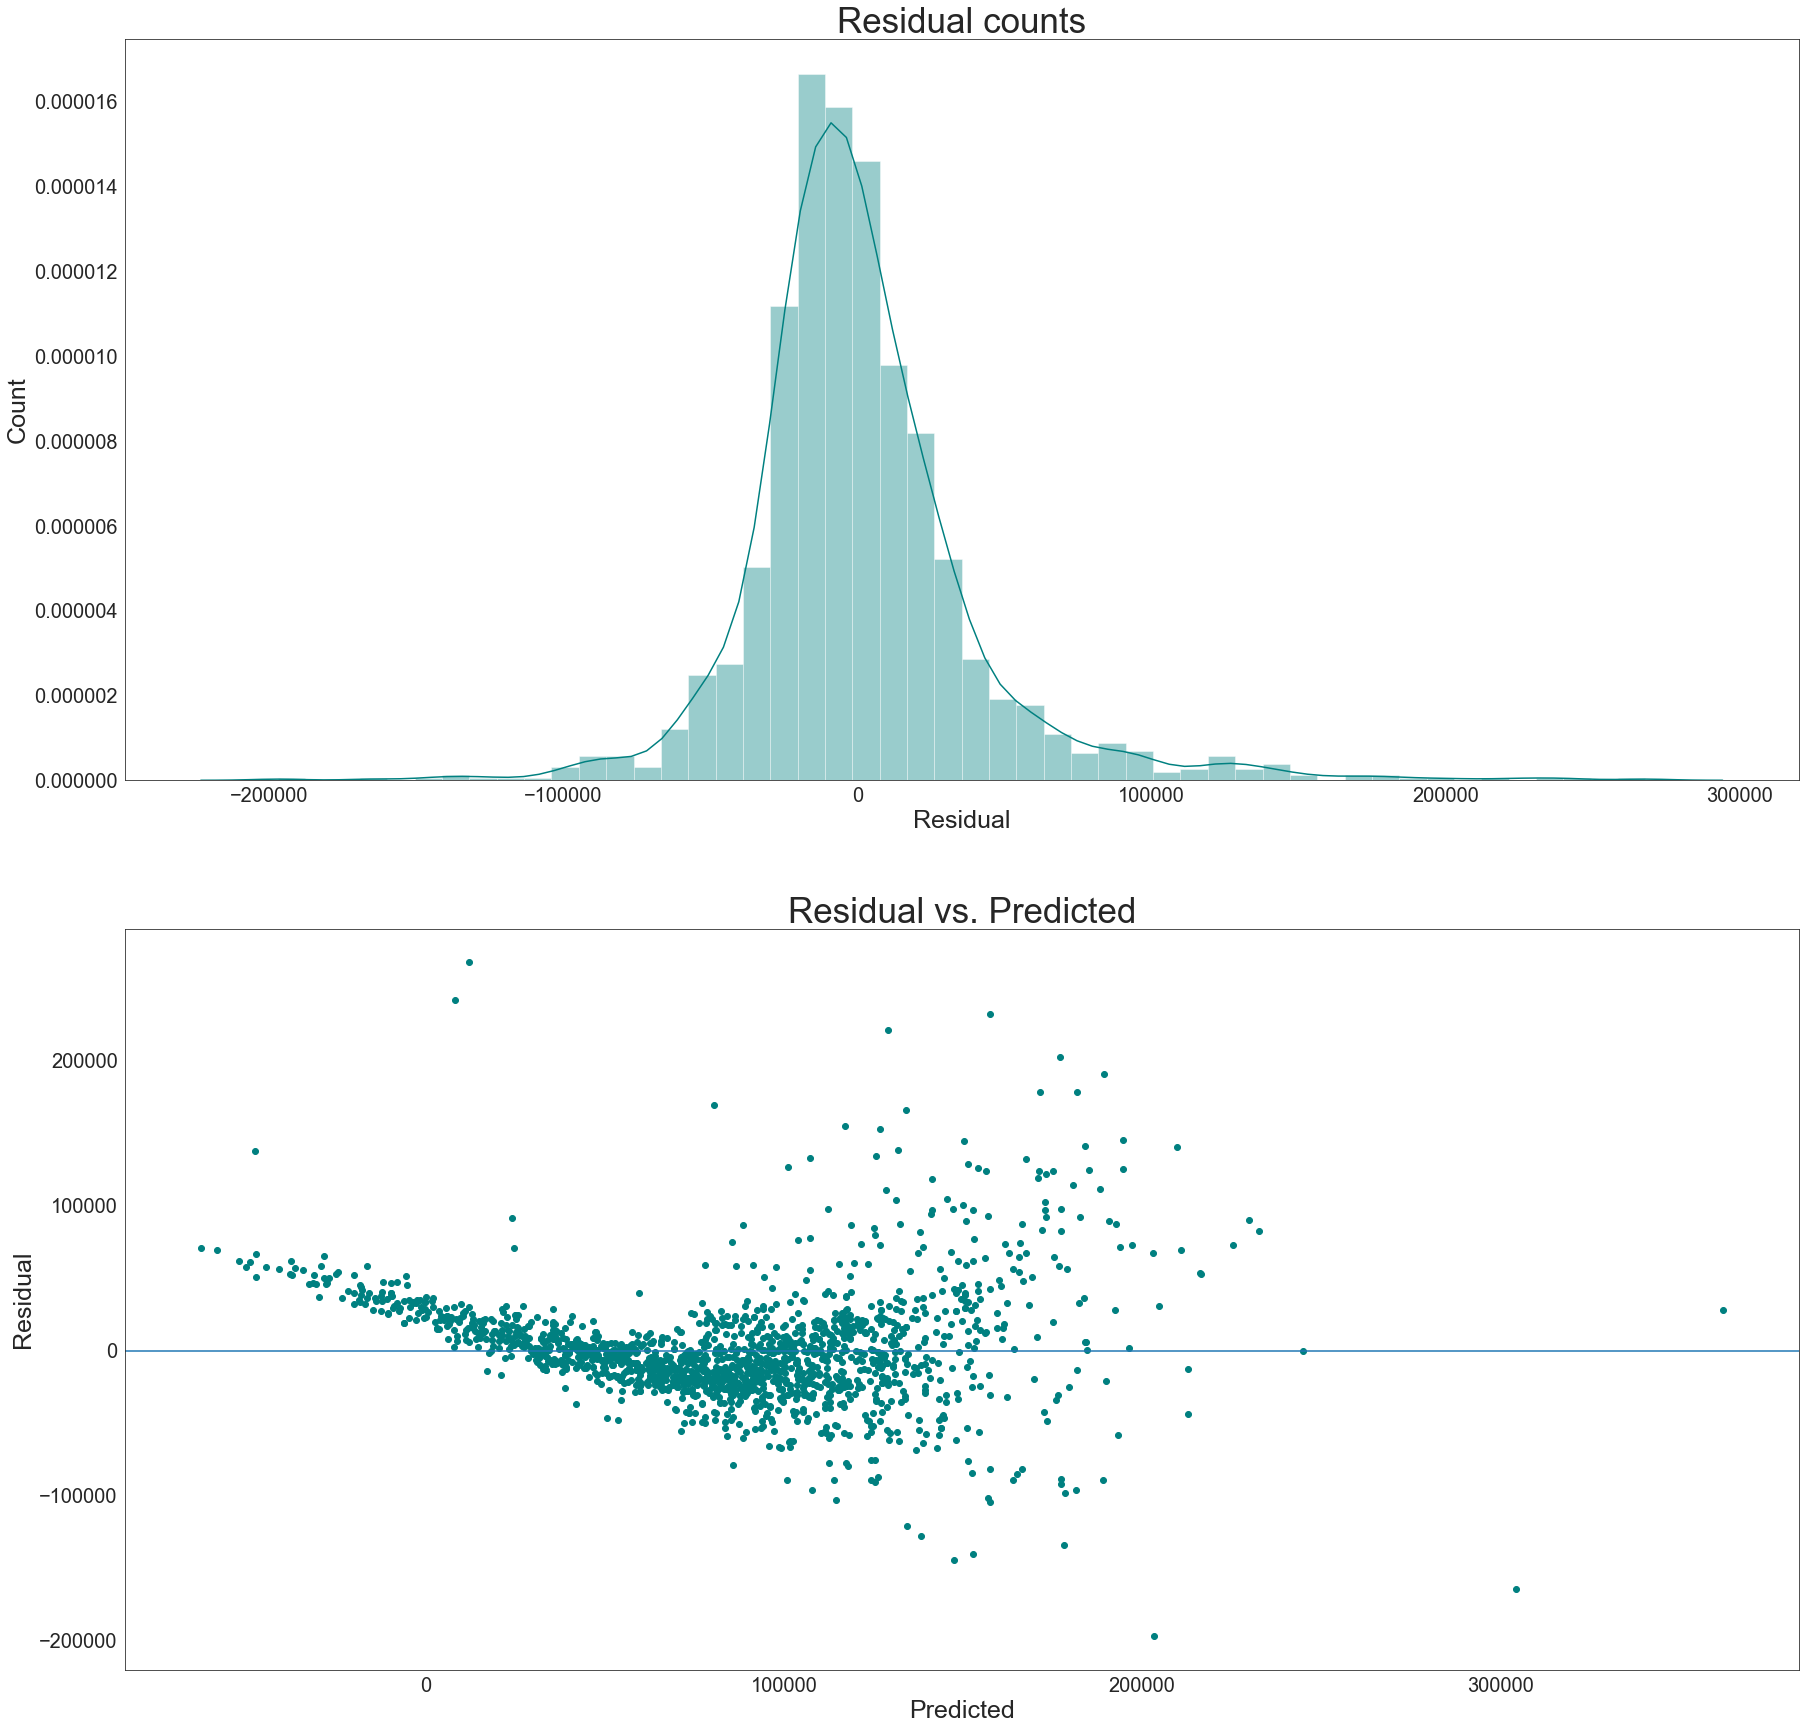

RMSE:
38725.92394287564


In [94]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

predicted = regr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

In [95]:
print('Variance score: %.2f' % r2_score(Y_test, predicted))

Variance score: 0.60


Boosting

In [96]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

r_sq = []
deep = []
mean_scores = []

#loss : {‘ls’, ‘lad’, ‘huber’, ‘quantile’}
for n in range(3, 11):
    gbr = GradientBoostingRegressor(loss ='ls', max_depth=n)
    gbr.fit (X, Y)
    deep.append(n)
    r_sq.append(gbr.score(X, Y))
    mean_scores.append(cross_val_score(gbr, X, Y, cv=12).mean())

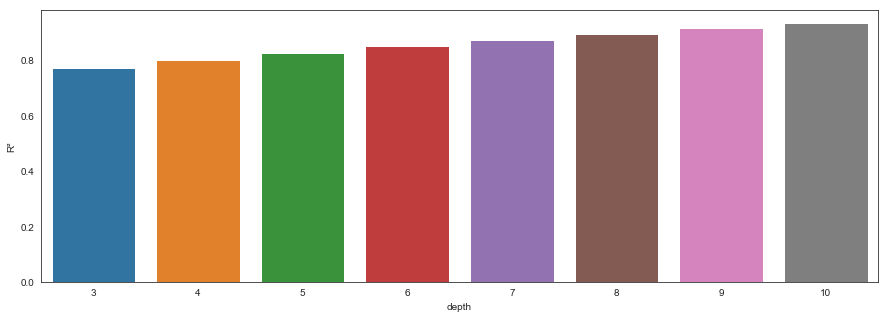

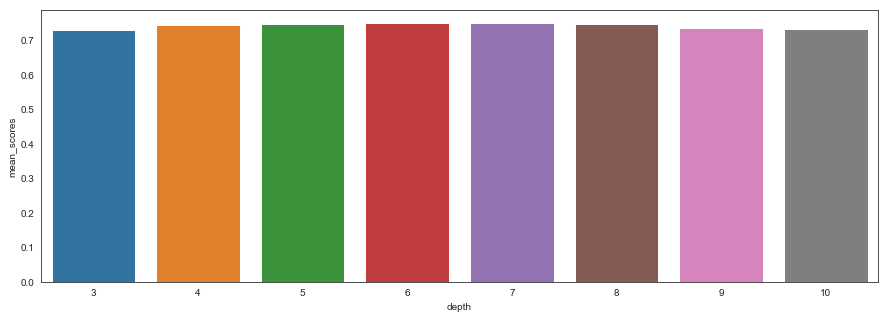

In [97]:
plt_gbr = pd.DataFrame()

plt_gbr['mean_scores'] = mean_scores
plt_gbr['depth'] = deep
plt_gbr['R²'] = r_sq

f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data = plt_gbr, x='depth', y='R²')
plt.show()

f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data = plt_gbr, x='depth', y='mean_scores')
plt.show()

e:\python\projects\deploying-machine-learning-model-to-heroku\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


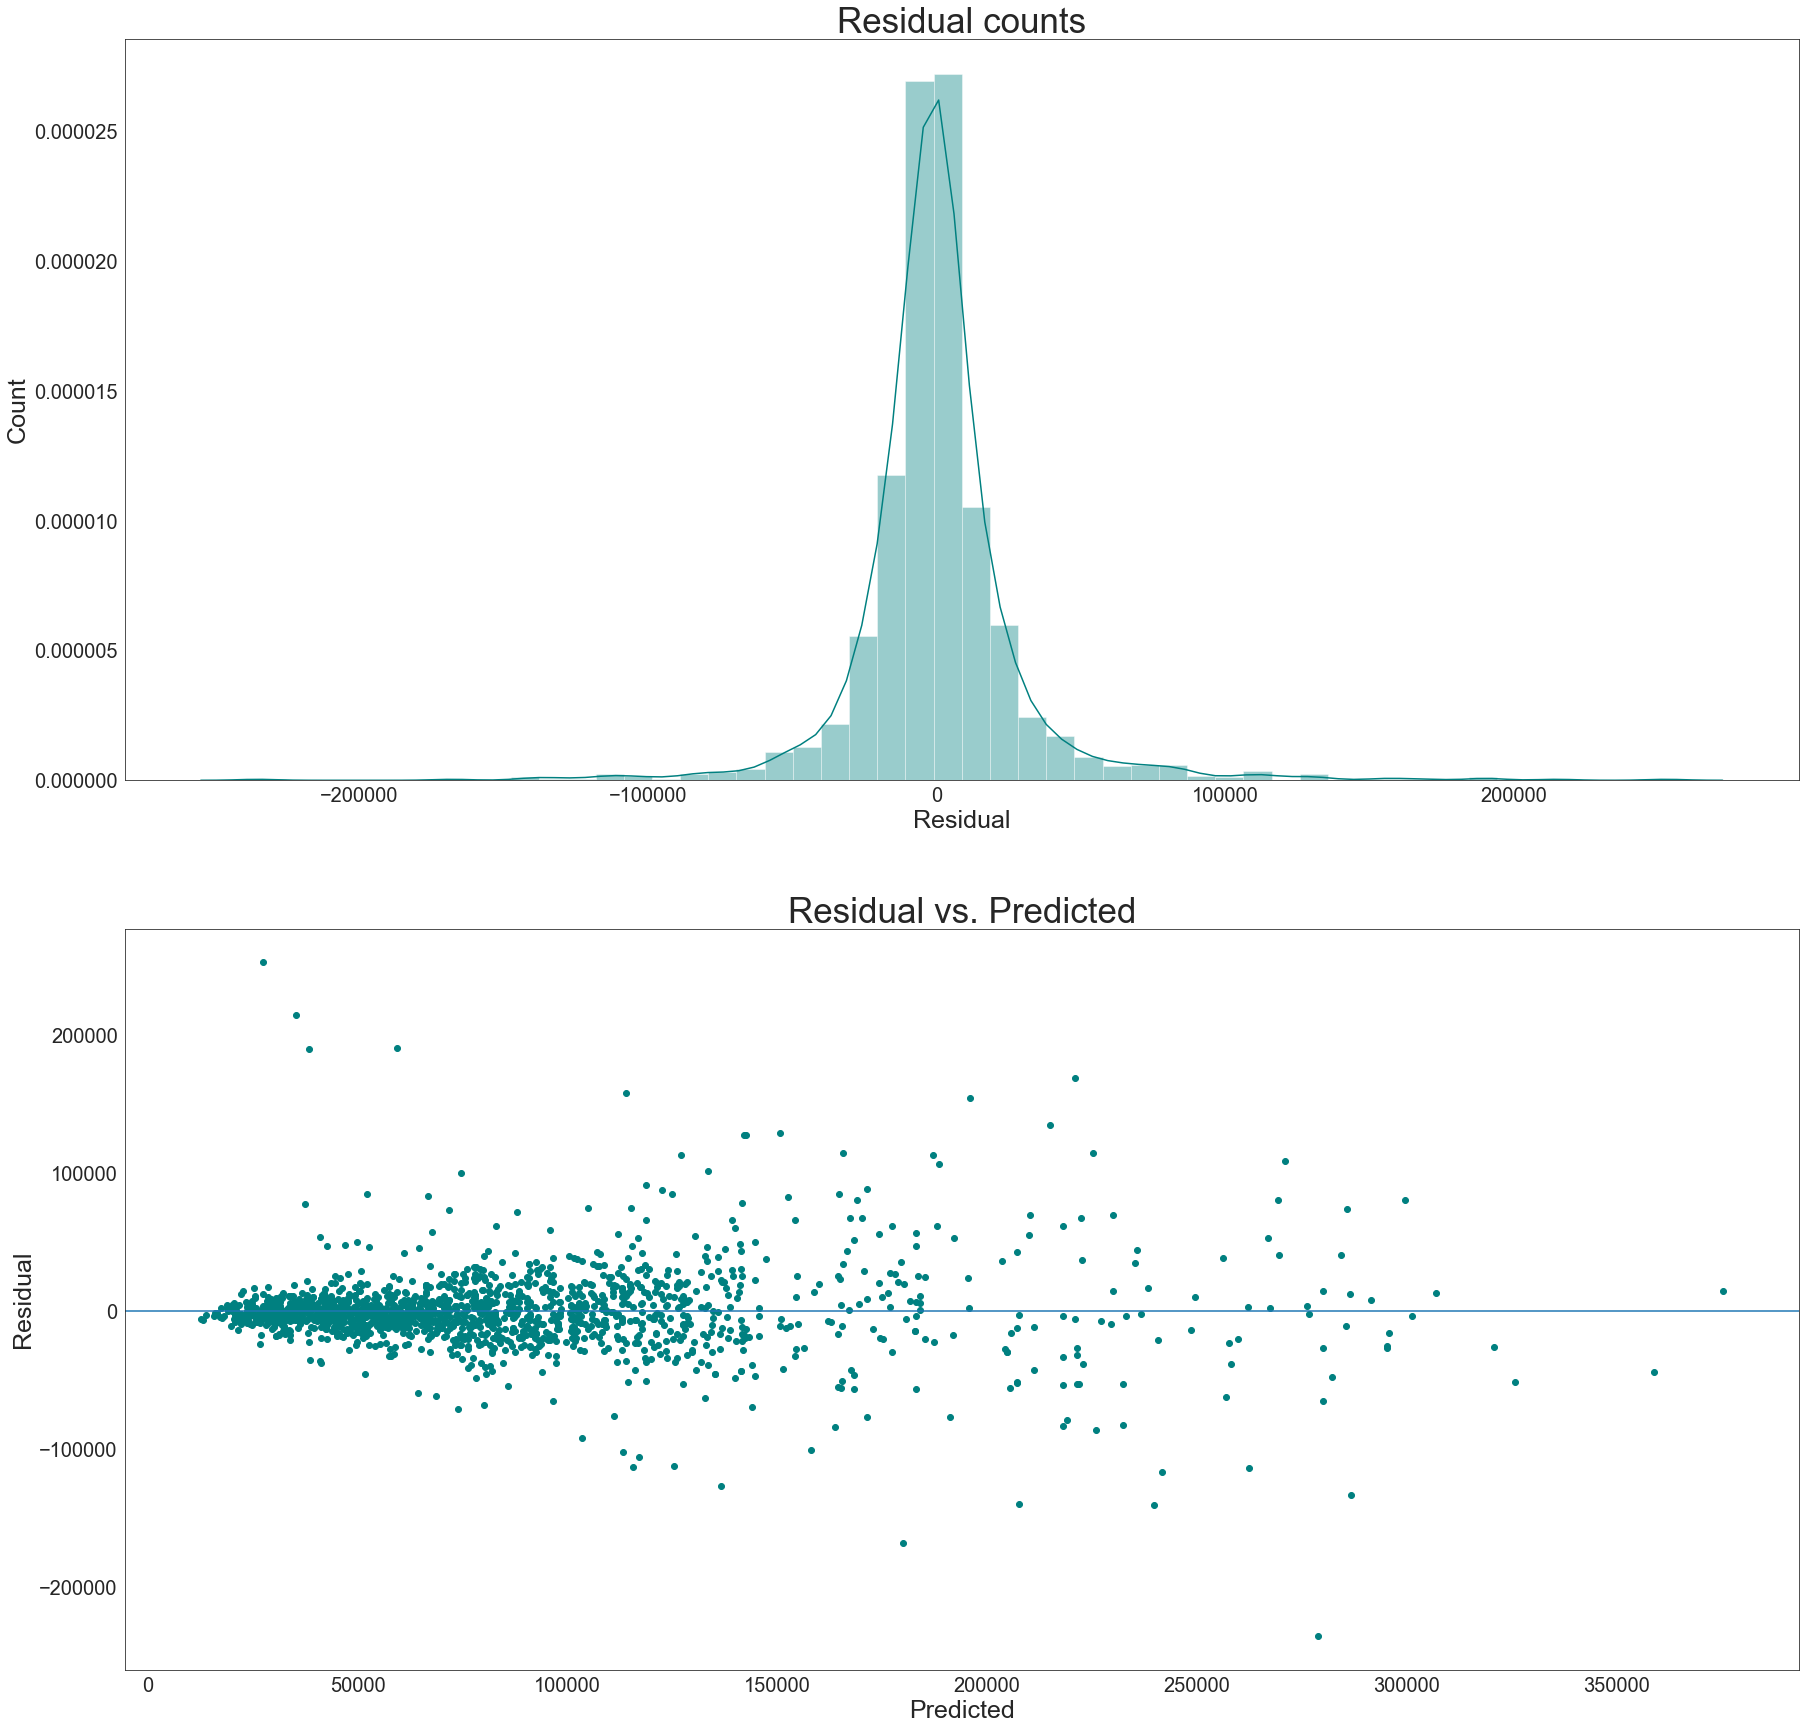


Cross Validation Scores:
[0.80463476 0.77301926 0.78535151 0.74293424 0.62204519 0.78280857
 0.80302066 0.78224303 0.72792044 0.60939424 0.7506151  0.80364726]

Mean Score:
0.7489695211871403

RMSE:
28945.464680850368


In [98]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbr = GradientBoostingRegressor(loss ='ls', max_depth=6)
gbr.fit (X_train, Y_train)
predicted = gbr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

rmse = np.sqrt(mean_squared_error(Y_test, predicted))
scores = cross_val_score(gbr, X, Y, cv=12)

print('\nCross Validation Scores:')
print(scores)
print('\nMean Score:')
print(scores.mean())
print('\nRMSE:')
print(rmse)

In [99]:
print('Variance score: %.2f' % r2_score(Y_test, predicted))

Variance score: 0.77


Prediction VS Real price histogram

In [103]:
Y_test

6855     82000
6831     57000
651     103000
5092    235000
858      77000
1598     46000
6818     35000
1977     49000
5446    145000
7426     69000
4364     85000
4766     75000
7646    105000
5133    160000
7112     53000
3598     73000
4705    220000
33       47000
1688     78000
371      68000
8003    135000
1087    135000
5129     38000
973      60000
7943    100000
6798     67000
1424    117000
6020     28000
7572     57000
8419     35000
         ...  
1816     60000
7820     48000
7389     42000
6532     50000
3638     72000
7179    350000
4656     37000
585     150000
7177     80000
4781    125000
1869     33000
8579     52000
3745    100000
3469    115000
4486    250000
6383    129000
2762     50000
8656     26000
7068     63000
1081    142000
7439    200000
5143     78000
434      37000
4420     95000
7682     50000
5902     13500
2798     42000
4310     50000
6536    228000
5412     30000
Name: price, Length: 1692, dtype: int32

In [107]:
predicted

array([101033.91748084,  59902.50551432,  80406.02713803, ...,
        47632.09594138,  38341.43557973,  57636.66096587])

In [109]:
A = Y_test.values.reshape(-1, 1)
B = predicted.reshape(-1, 1)

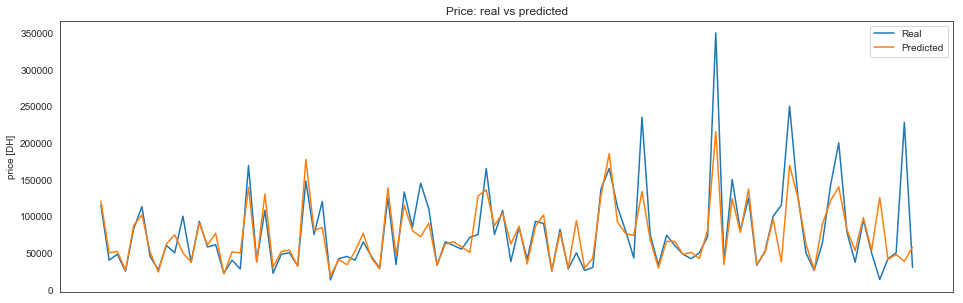

In [110]:
plt.rcParams['figure.figsize'] = 16,5
plt.figure()
plt.plot(A[-100:], label="Real")
plt.plot(B[-100:], label="Predicted")
plt.legend()
plt.title("Price: real vs predicted")
plt.ylabel("price [DH]")
plt.xticks(())
plt.show()

predict new

In [117]:
# user_input = [2010, 124999.5, 6, 'Diesel', 'BMW']
user_input = {'year_model':2006, 'mileage':82499.5, 'fiscal_power':6, 'fuel_type':'Diesel', 'mark':'Dacia'}
def input_to_one_hot(data):
    # initialize the target vector with zero values
    enc_input = np.zeros(62)
    # set the numerical input as they are
    enc_input[0] = data['year_model']
    enc_input[1] = data['mileage']
    enc_input[2] = data['fiscal_power']
    ##################### Mark #########################
    # get the array of marks categories
    marks = df.mark.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'mark_'+data['mark']
    # search for the index in columns name list 
    mark_column_index = X.columns.tolist().index(redefinded_user_input)
    #print(mark_column_index)
    # fullfill the found index with 1
    enc_input[mark_column_index] = 1
    ##################### Fuel Type ####################
    # get the array of fuel type
    fuel_types = df.fuel_type.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'fuel_type_'+data['fuel_type']
    # search for the index in columns name list 
    fuelType_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[fuelType_column_index] = 1
    return enc_input

In [118]:
print(input_to_one_hot(user_input))

[2.00600e+03 8.24995e+04 6.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00]


In [119]:
a = input_to_one_hot(user_input)

In [120]:
price_pred = gbr.predict([a])

In [121]:
price_pred[0]

56702.73443621002

save model

In [122]:
from sklearn.externals import joblib

joblib.dump(gbr, 'model.pkl')

['model.pkl']

In [123]:
gbr = joblib.load('model.pkl')

In [124]:
print("the best price for this Dacia is",gbr.predict([a])[0])

the best price for this Dacia is 56702.73443621002


Build RESI API

In [132]:
import requests, json
url = "http://127.0.0.1:5000/api"
data = json.dumps({'year_model':2014, 'mileage':12499.5, 'fiscal_power':7, 'fuel_type':'Diesel', 'mark':'Mercedes-Benz'})

r = requests.post(url, data)

print(r.json())

 

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /api (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1260AF90>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

r.json()['results'][0]